Создаем спарк-сессию. Задаем переменную spark.sql.pivotMaxValues равную 20000, 
так как данных для функции pivot() будет больше дефолтного значения (10000).

In [1]:
from pyspark import SparkContext, SQLContext
import random
sc = SparkContext.getOrCreate()
spark = SQLContext(sc)

In [2]:
import pandas as pd
from pyspark.sql import SQLContext, SparkSession
sqlContext = SQLContext.getOrCreate(sc)
sparkSession = SparkSession.builder.master('local').appName("Book advices").config("spark.sql.pivotMaxValues", "20000").getOrCreate()

In [3]:
books = spark.read.csv('./BX-Books.csv', sep=';', header=True)
users = spark.read.csv('./BX-Users.csv', sep=';', header=True)
books_ratings = spark.read.csv('./BX-Book-Ratings.csv', sep=';', header=True)

In [4]:
books_ratings.printSchema()

root
 |-- User-ID: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: string (nullable = true)



In [5]:
print(books_ratings.count(),len(books_ratings.columns))

1149780 3


In [6]:
books_ratings.show(5)

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276725|034545104X|          0|
| 276726|0155061224|          5|
| 276727|0446520802|          0|
| 276729|052165615X|          3|
| 276729|0521795028|          6|
+-------+----------+-----------+
only showing top 5 rows



считаем количество каждой из оценок

In [7]:
#books_ratings.select('Book-Rating')
books_ratings.groupBy('Book-Rating').count().show()

+-----------+------+
|Book-Rating| count|
+-----------+------+
|          7| 76457|
|          3|  5996|
|          8|103736|
|          0|716109|
|          5| 50974|
|          6| 36924|
|          9| 67541|
|          1|  1770|
|         10| 78610|
|          4|  8904|
|          2|  2759|
+-----------+------+



Покажем распределение оценок на графике

In [8]:
data = pd.DataFrame(books_ratings.groupBy('Book-Rating').count().take(books_ratings.groupBy('Book-Rating').count().count()))
data.columns = ['Book-Rating', 'count']
data['Book-Rating'] = data['Book-Rating'].astype(int)
data = data.sort_values(by='Book-Rating')
data.index = data['Book-Rating']

In [9]:
import matplotlib.pyplot as plt
plt.rc("font", size=15)
data['count'].plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

In [10]:
books.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)



In [11]:
print(books.count(),len(books.columns))

271379 8


In [12]:
books.show(5)

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|         Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0195153448| Classical Mythology|  Mark P. O. Morford|               2002|Oxford University...|http://images.ama...|http://images.ama...|http://images.ama...|
|0002005018|        Clara Callan|Richard Bruce Wright|               2001|HarperFlamingo Ca...|http://images.ama...|http://images.ama...|http://images.ama...|
|0060973129|Decision in Normandy|        Carlo D'Este|               1991|     HarperPerennial|http://images.ama...|http://images.ama...|http://images.ama...|
|0374157065|Flu: The Story of...|    Gina Bari

Смотрим на топ-5 самых оцениваемых книг

In [13]:
top_rated_books = books_ratings.groupBy('ISBN').count().orderBy('count', ascending=False)
top_rated_books.show(5)

+----------+-----+
|      ISBN|count|
+----------+-----+
|0971880107| 2502|
|0316666343| 1295|
|0385504209|  883|
|0060928336|  732|
|0312195516|  723|
+----------+-----+
only showing top 5 rows



In [14]:
users.printSchema()

root
 |-- User-ID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



In [15]:
print(users.count(),len(users.columns))

278859 3


In [16]:
users.show(5)

+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|NULL|
|      2|stockton, califor...|  18|
|      3|moscow, yukon ter...|NULL|
|      4|porto, v.n.gaia, ...|  17|
|      5|farnborough, hant...|NULL|
+-------+--------------------+----+
only showing top 5 rows



смотрим на распределение возраста

In [17]:
data = pd.DataFrame(users.select('Age').take(users.select('Age').count()))

In [18]:
import numpy as np
data.columns = ['Age']
data.at[data["Age"] == 'NULL','Age'] = np.nan
data["Age"] = data["Age"].astype(float, errors='ignore')

In [19]:
data['Age'].describe()

count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64

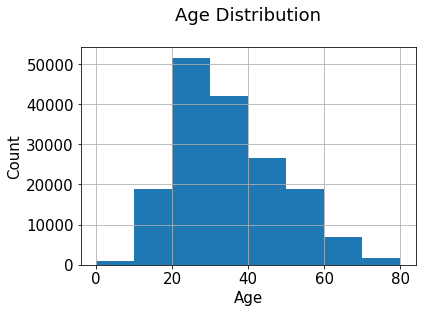

In [21]:
plt.rc("font", size=15)
data['Age'].hist(bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

отображаем информацию по топу-5 самых оцениваемых книг

In [24]:
top_rated_books = books_ratings.groupBy('ISBN').count().orderBy('count', ascending=False)
ids = top_rated_books.take(5)

In [25]:
ids = [x[0] for x in ids]

In [26]:
ids

['0971880107', '0316666343', '0385504209', '0060928336', '0312195516']

In [27]:
from pyspark.sql.functions import col
books.where(col('ISBN').isin(ids)).show()

+----------+--------------------+-------------+-------------------+-------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|  Book-Author|Year-Of-Publication|    Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+-------------+-------------------+-------------+--------------------+--------------------+--------------------+
|0971880107|         Wild Animus| Rich Shapero|               2004|      Too Far|http://images.ama...|http://images.ama...|http://images.ama...|
|0316666343|The Lovely Bones:...| Alice Sebold|               2002|Little, Brown|http://images.ama...|http://images.ama...|http://images.ama...|
|0312195516|The Red Tent (Bes...|Anita Diamant|               1998|  Picador USA|http://images.ama...|http://images.ama...|http://images.ama...|
|0385504209|   The Da Vinci Code|    Dan Brown|               2003|    Doubleday|http://images.ama...|http://images.ama...|http://

другой способ

In [28]:
most_rated_books = books.where(col('ISBN').isin(ids))
most_rated_books.show()

+----------+--------------------+-------------+-------------------+-------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|  Book-Author|Year-Of-Publication|    Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+-------------+-------------------+-------------+--------------------+--------------------+--------------------+
|0971880107|         Wild Animus| Rich Shapero|               2004|      Too Far|http://images.ama...|http://images.ama...|http://images.ama...|
|0316666343|The Lovely Bones:...| Alice Sebold|               2002|Little, Brown|http://images.ama...|http://images.ama...|http://images.ama...|
|0312195516|The Red Tent (Bes...|Anita Diamant|               1998|  Picador USA|http://images.ama...|http://images.ama...|http://images.ama...|
|0385504209|   The Da Vinci Code|    Dan Brown|               2003|    Doubleday|http://images.ama...|http://images.ama...|http://

In [29]:
from pyspark.sql import functions as F

average_rating = books_ratings.groupBy('ISBN').agg(F.mean('book-rating'), F.count('book-rating')).orderBy('count(book-rating)', ascending=False)
average_rating.show(5)

+----------+------------------+------------------+
|      ISBN|  avg(book-rating)|count(book-rating)|
+----------+------------------+------------------+
|0971880107|1.0195843325339728|              2502|
|0316666343| 4.468725868725869|              1295|
|0385504209| 4.652321630804077|               883|
|0060928336| 3.448087431693989|               732|
|0312195516| 4.334716459197787|               723|
+----------+------------------+------------------+
only showing top 5 rows



в файле Recommender Systems - The Fundamentals.ipynb были неверно удалены книги с количеством оценок больше 100 - 
на самом деле удалялись все оценки (от 0 до 10), которых в данных меньше 100 штук (в данном случае не удалилось ничего,
т.к. всех оценок больше)

после удаления книг с количеством оценок больше 100 данных остается совсем мало. но в данном примере удалялись именно они 
для ускорения работы программы, т.к. корреляция для бОльшего количества данных считается достаточно долго)

In [31]:
counts1 = books_ratings.groupBy('User-ID').count()
#counts1.show()
user_ids = counts1.where(col('count') >= 200).select('User-ID').collect()
user_ids = [ x["User-ID"] for x in user_ids]
ratings = books_ratings.where(col('User-ID').isin(user_ids))
#ratings.show()
counts = books_ratings.groupBy('ISBN').count()
#print(counts.count())
books_ids = counts.where(col('count') >= 100).select('ISBN').collect()
#print(books_ids.count())
books_ids = [x['ISBN'] for x in books_ids]
#print(len(books_ids))
#counts.show()
ratings = ratings.where(col('ISBN').isin(books_ids))
ratings.show()
print(ratings.count())

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 277427|002542730X|         10|
| 277427|0060930535|          0|
| 277427|0060934417|          0|
| 277427|0061009059|          9|
| 277427|0140067477|          0|
| 277427|014029628X|          0|
| 277427|014100018X|          0|
| 277427|0142001740|          0|
| 277427|0312966091|          0|
| 277427|031298328X|          0|
| 277427|0316096199|          0|
| 277427|0316168688|          0|
| 277427|0316284955|          0|
| 277427|0316569321|          0|
| 277427|0316602051|          0|
| 277427|0316666343|          0|
| 277427|0316776963|          8|
| 277427|0316777730|          0|
| 277427|0345339681|          0|
| 277427|0345361792|          0|
+-------+----------+-----------+
only showing top 20 rows

49781


In [32]:
from pyspark.sql.functions import first
ratings_pivot = ratings.groupBy('User-ID').pivot('ISBN').agg(first('Book-Rating'))

In [33]:
print(ratings_pivot.count(), len(ratings_pivot.columns))

888 732


In [34]:
ratings_pivot = ratings_pivot.drop('User-ID')

In [35]:
print(ratings_pivot.count(), len(ratings_pivot.columns))

888 731


переводим оценки в тип данных Integer

In [36]:
from pyspark.sql.types import IntegerType
ratings_pivot = ratings_pivot.select(*(col(c).cast("int").alias(c) for c in ratings_pivot.columns))

In [37]:
print(ratings_pivot.count(), len(ratings_pivot.columns))

888 731


In [38]:
bones_ratings = ratings_pivot.select('0316666343')
#bones_ratings.show()
index = 0
similar_to_bones = []
for c in ratings_pivot.columns:
    if index%50 == 0:
        print(index)
    index += 1
    similar_to_bones.append(ratings_pivot.stat.corr('0316666343', c))
print(similar_to_bones)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
[0.02114984679937612, -0.014196608430810456, 0.019049736543522777, -0.026338630425962625, -0.029292235101184845, 0.09668742514107928, 0.09056139632781433, -0.000707954673909693, 0.03265852974745779, 0.051571827540255175, 0.00678992863016239, 0.0818866263995274, 0.021078968500377628, 0.04024416557642337, 0.06170511959442472, 0.08972255436985692, 0.12842607210826607, 0.14567419619147484, 0.08983420956738446, 0.12662870470148188, 0.07030742046317787, 0.07812437320403917, 0.0021262277010224134, 0.0704642316431199, 0.043490568216024414, 0.04960659119574528, 0.165711188814135, 0.1255671202450514, 0.04881773636249712, 0.0680465899261919, 0.004394986702995633, -0.0026148340234678235, 0.04735358095309549, 0.07806108023756865, 0.07903183454744522, 0.03327783923803971, -0.044158728775577104, 0.005569771247883874, 0.05920941057684971, 0.051709831820436356, 0.056010831091149856, 0.08793970188839811, 0.009470084505218966, 0.005302923866089577,

сортируем данные по корреляции с нужной нам книгой.

In [42]:
from pyspark.sql.types import FloatType
average_rating = ratings.groupBy('ISBN').agg(F.mean('book-rating'), F.count('book-rating')).orderBy('count(book-rating)', ascending=False)
s_index = sorted(range(len(similar_to_bones)), key=lambda k: similar_to_bones[k], reverse = True)
columns = [ratings_pivot.columns[c] for c in s_index[:300]] 
similar_to_bones = [similar_to_bones[i] for i in s_index[:300]]

isbn_similar = average_rating.where(col('ISBN').isin(columns)).drop('avg(book-rating)')
isbn_similar.show()

+----------+------------------+
|      ISBN|count(book-rating)|
+----------+------------------+
|0316666343|              1295|
|0385504209|               883|
|0060928336|               732|
|0312195516|               723|
|0142001740|               615|
|0316601950|               568|
|0375727345|               552|
|0345337662|               506|
|0060930535|               494|
|0312278586|               474|
|0345370775|               466|
|0156027321|               462|
|0060976845|               434|
|0345361792|               412|
|0345417623|               407|
|0316769487|               403|
|0385484518|               391|
|0375706771|               380|
|0060502258|               376|
|0345353145|               368|
+----------+------------------+
only showing top 20 rows



отображаем 10 рекомендованных книг (сама книга тоже попала в список, т.к. корреляция = 1)

In [43]:
#books_corr_to_bones =columns[:10] #isbn_similar.select('ISBN').take(10)
#print(books_corr_to_bones)
isbn =columns[:10]# [x['ISBN'] for x in books_corr_to_bones]
books.where(col('ISBN').isin(isbn)).show()

+----------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      ISBN|          Book-Title|       Book-Author|Year-Of-Publication|           Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|
+----------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0060173289|Divine Secrets of...|     Rebecca Wells|               1996|       HarperCollins|http://images.ama...|http://images.ama...|http://images.ama...|
|006019491X|Daughter of Fortu...|    Isabel Allende|               1999|       HarperCollins|http://images.ama...|http://images.ama...|http://images.ama...|
|0060175400|The Poisonwood Bible|Barbara Kingsolver|               1999|       HarperCollins|http://images.ama...|http://images.ama...|http://images.ama...|
|0060392452|Stupid White Men ...|     Michael Moore|      